Informations:
* Data collecting tool: **Atop**  
* Features extraction tool: **Atop**

In [2]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import json

folder = os.path.join("..", "0_dataset", "accounting")
filenames = ['label_atop_mirai.csv', 'label_atop_disk_wipe.csv', 'label_atop_ransomware.csv',
                  'label_atop_resource_hijacking.csv', 'label_atop_end_point_dos.csv']
filename_label = 'preprocess_label_atop.csv'
label_table_path = 'labels_table.json'

ImportError: this version of pandas is incompatible with numpy < 1.20.3
your numpy version is 1.19.2.
Please upgrade numpy to >= 1.20.3 to use this pandas version

1. Preprocessing

In [ ]:
one_hot_col_list = ['POLI', 'ST', 'EXC', 'S']
# removed_fields = ['TIMESTAMP', 'PID', 'CMD', 'Hostname', 'Tactic', 'Technique', 'SubTechnique']
removed_fields = ['PID', 'CMD', 'Hostname', 'Tactic', 'Technique', 'SubTechnique']
replace_strings = {'%': '', 'K': '000', 'M': '000000', 'G': '000000000'}
remove_rows_with_str = {'-': '0'}

df = pd.DataFrame()
for tmp_filename in filenames:
    print("\n")
    print("-------------------------------------\n")
    print("file name:{0}".format(tmp_filename))
    filename = os.path.join(folder, tmp_filename)
    tmp_df = pd.read_csv(filename)

    # simple analysis
    labels = sorted(tmp_df['Label'].unique())
    print('labels: {0}'.format(labels))
    
    df = pd.concat([df, tmp_df])

# simple analysis
labels = sorted(df['Label'].unique())
print('label uniques: {0}'.format(labels))
print('number of timestamp: {0}'.format(len(df['TIMESTAMP'].unique())))

# delete useless features
df.drop(columns=removed_fields, axis=1, inplace=True)

# one-hot-encoding
df = pd.get_dummies(df, columns=one_hot_col_list)

df.drop_duplicates(keep=False, inplace=True)

# string replacement
for old_value, new_value in replace_strings.items():
    df = df.replace(to_replace=old_value, value=new_value, regex=True)
for old_value, new_value in remove_rows_with_str.items():
    df = df.replace(to_replace=old_value, value=new_value)

# turn to number
for k in list(df):
    df[k] = pd.to_numeric(df[k], errors='ignore')

print(df.info(verbose=True))

output_filename = os.path.join(folder, filename_label)
df.to_csv(output_filename, encoding='utf-8', index=False)



-------------------------------------

file name:label_atop_mirai.csv
labels: [0, 1, 2, 3, 5, 9, 11, 12]


-------------------------------------

file name:label_atop_disk_wipe.csv
labels: [0, 1, 4, 8, 14]


-------------------------------------

file name:label_atop_ransomware.csv
labels: [0, 1, 7, 12, 15]


-------------------------------------

file name:label_atop_resource_hijacking.csv
labels: [0, 1, 6, 8, 16]


-------------------------------------

file name:label_atop_end_point_dos.csv
labels: [0, 4, 8, 10, 12, 17]
label uniques: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 17]
number of timestamp: 10309
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2702562 entries, 0 to 600599
Data columns (total 47 columns):
 #   Column     Dtype  
---  ------     -----  
 0   TIMESTAMP  float64
 1   RDDSK      int64  
 2   WRDSK      int64  
 3   WCANCL     int64  
 4   DSK        int64  
 5   MINFLT     float64
 6   MAJFLT     int64  
 7   VSTEXT     int64  
 8   VSIZE      

2. training preparation

In [ ]:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer, QuantileTransformer, PowerTransformer
from sklearn.feature_selection import VarianceThreshold

df = pd.read_csv(os.path.join(folder, filename_label))
del_list = ['TIMESTAMP']

sample_num = 50000

print("origin data number: {0}".format(len(df.index)))
print("origin features: {0}".format(len(df.columns)-1))


# data cleaning
df.drop_duplicates(keep=False, inplace=True)
df.drop(columns=del_list, inplace=True)

for label in df['Label'].unique():
    if len(df[df['Label'] == label]) > sample_num:
        df_tmp = df.loc[df['Label'] == label].copy()
        df_tmp.drop_duplicates(keep=False, inplace=True)
        df_tmp = df_tmp.sample(n=sample_num, random_state=47)
        df.drop(df[df['Label'] == label].index, inplace=True)
        df = pd.concat([df, df_tmp])

for class_label in df['Label'].unique():
    while len(df[df['Label'] == class_label]) < 20:
        tmp_df = df[df['Label'] == class_label]
        df = pd.concat([df, tmp_df])

# # feature scaling
# y_tmp = df['Label']
# df.drop(columns=['Label'], inplace=True)
# for feature in df.columns.values:
#     # scaler = RobustScaler().fit(df[feature].values.reshape(-1, 1))
#     scaler = StandardScaler().fit(df[feature].values.reshape(-1, 1))
#     # scaler = Normalizer().fit(df[feature].values.reshape(-1, 1))
#     # scaler = QuantileTransformer().fit(df[feature].values.reshape(-1, 1))
#     # scaler = PowerTransformer().fit(df[feature].values.reshape(-1, 1))
#     df[feature] = scaler.transform(df[feature].values.reshape(-1, 1))
# df = pd.concat([df, y_tmp], axis=1)


# feature selection
# delete features with all the same value
y_tmp = df['Label']
df.drop('Label', axis=1, inplace=True)
selector = VarianceThreshold(threshold=0)
selector.fit(df)
print(selector.variances_)
constant_columns = [column for column in df.columns
                    if column not in 
                    df.columns[selector.get_support()]]
df.drop(labels=constant_columns, axis=1, inplace=True)

# delete similar features
df_tmp = df
corr_features = set()
corr_matrix = df_tmp.corr()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            colname = corr_matrix.columns[i]
            corr_features.add(colname)
df.drop(labels=corr_features, axis=1, inplace=True)

df = pd.concat([df, y_tmp], axis=1)


print("remain data number: {0}".format(len(df.index)))
print("remain features: {0}".format(len(df.columns)-1))

output_file = os.path.join(folder, "select_"+filename_label)
df.to_csv(output_file, encoding='utf-8', index=False)

origin data number: 2702562
origin features: 46
[4.58400000e+06 6.96200000e+07 2.37600000e+06 1.00000000e+02
 5.23490000e+04 7.30222672e-03 4.58110000e+07 7.23520000e+07
 9.98400000e+07 7.32120000e+07 4.61520000e+07 3.28718367e+00
 2.01723133e-01 3.47302815e+01 8.56426249e-05 3.90000000e+01
 1.39000000e+02 0.00000000e+00 2.15031622e-01 1.27785753e+01
 6.26087259e-02 0.00000000e+00 6.26087259e-02 0.00000000e+00
 1.41182678e-01 1.90527686e-02 9.41261923e-04 9.24008704e-02
 3.64919592e-02 8.73209926e-03 6.26087259e-02 5.00314378e-02
 5.77818273e-03 1.22355590e-05 6.11748006e-05 1.22355590e-05
 7.51653966e-03 3.67057787e-05 7.82472134e-04 7.34088625e-05
 6.26087259e-02 3.67057787e-05 1.54049237e-01 1.92257312e-01
 2.23412097e-03]
remain data number: 81728
remain features: 38


3. Visualization (data number)


Data number:
class0: 50000
class1: 7932
class2: 69
class3: 32
class4: 193
class5: 21
class6: 1493
class7: 1457
class8: 6177
class9: 62
class10: 32
class11: 9578
class12: 3611
class14: 537
class15: 216
class16: 36
class17: 282


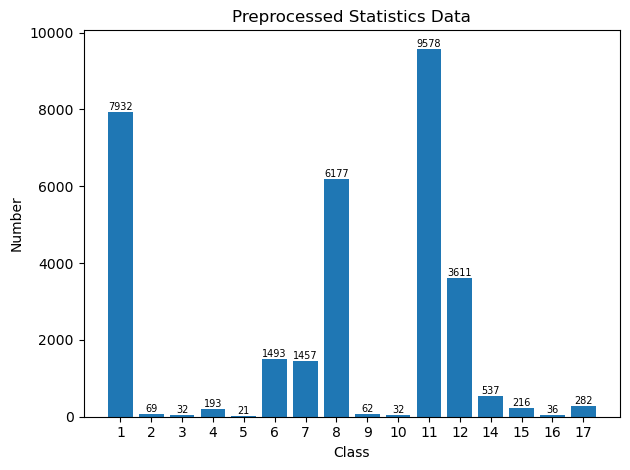

In [ ]:
def bar_class_num(technique_data_size):
    class_num = np.arange(len(technique_data_size))
    # data_nums = plt.bar(class_num, technique_data_size, 0.2)
    data_nums = plt.bar(class_num, technique_data_size)
    for item in data_nums:
        height = item.get_height()
        plt.text(
            item.get_x()+item.get_width()/2., 
            height, 
            '%d' % int(height),
            ha = "center",
            va = "bottom",
            fontsize = 7,
        )
    labels.pop(0)
    plt.xticks(class_num, labels)
    plt.xlabel("Class")
    plt.ylabel("Number")
    plt.title("Preprocessed Statistics Data")
    # plt.title("Raw Statistics Data")
    plt.tight_layout()
    plt.savefig("accounting.png", dpi=400)
    plt.show()

technique_data_size = []
df = pd.read_csv(os.path.join(folder, 'select_'+filename_label))
# df = pd.read_csv(os.path.join(folder, "preprocess_label_atop.csv"))
labels = df['Label'].unique()
labels = [int(i) for i in labels]
labels.sort()
with open("labels_table.json", "r") as f:
    label_table = json.load(f)

for i in labels:
    if i != 0:
        class_data_size = len(df[df['Label'] == i])
        technique_data_size.append(class_data_size)

print("\nData number:")
for i in labels:
    print("class{0}: {1}".format(i, len(df[df['Label'] == i])))

bar_class_num(technique_data_size)